<h1 style="font-size:30px;">DeepLabv3+ with ResNet50_v2 Backbone</h1>

In [39]:
!pip install -q git+https://github.com/keras-team/keras-cv.git --upgrade

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [40]:
import os
import requests
from zipfile import ZipFile
import glob
from dataclasses import dataclass, field

import random
import numpy as np
import cv2

import tensorflow as tf
import keras_cv

import matplotlib.pyplot as plt

## Set Seeds for Reproducibility

In [41]:
def system_config(SEED_VALUE):
    # Set python `random` seed.
    # Set `numpy` seed
    # Set `tensorflow` seed.
    random.seed(SEED_VALUE)
    tf.keras.utils.set_random_seed(SEED_VALUE)
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'
    os.environ['TF_USE_CUDNN'] = "true"

system_config(SEED_VALUE=42)

## Download and Extract Dataset

In [42]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
# Define the dataset directory path
DATASET_DIR = "/content/drive/MyDrive/training_set"

# Check if the dataset directory exists
if os.path.exists(DATASET_DIR):
    print(f"Dataset directory exists: {DATASET_DIR}")
else:
    print(f"Dataset directory does not exist: {DATASET_DIR}")

# Example of constructing a path to a specific file within the dataset directory
example_file_name = "example.txt"
example_file_path = os.path.join(DATASET_DIR, example_file_name)

# Code to handle the file (e.g., reading, writing, etc.)
# For example, to create an example file in the dataset directory:
with open(example_file_path, 'w') as file:
    file.write("This is an example file.")

# Print the paths for verification
print(f"Dataset directory path: {DATASET_DIR}")
print(f"Example file path: {example_file_path}")


Dataset directory exists: /content/drive/MyDrive/training_set
Dataset directory path: /content/drive/MyDrive/training_set
Example file path: /content/drive/MyDrive/training_set/example.txt


## Configurations

In [44]:
@dataclass(frozen=True)
class TrainingConfig:
    MODEL: str = "resnet50_v2_imagenet"
    EPOCHS: int = 35
    LEARNING_RATE: float = 1e-4
    CKPT_DIR: str = os.path.join("checkpoints", "deeplabv3_plus_"+"_".join(MODEL.split("_")[:2])+".h5")
    LOGS_DIR: str = "logs_"+"_".join(MODEL.split("_")[:2])

@dataclass(frozen=True)
class DatasetConfig:
    IMAGE_SIZE:        tuple = (128, 128)
    BATCH_SIZE:          int = 8
    NUM_CLASSES:         int = 2
    BRIGHTNESS_FACTOR: float = 0.2
    CONTRAST_FACTOR:   float = 0.4
    DATASET_DIR: str = "dataset"

In [45]:
train_config = TrainingConfig()
data_config = DatasetConfig()

## Dataset Preparation

In [46]:
# Get the list of image and mask paths
data_images = glob.glob(os.path.join(DATASET_DIR, "training_set", "*HC.png"))
data_masks = glob.glob(os.path.join(DATASET_DIR, "Masks", "*HC.png"))

# Print lengths of data_images and data_masks
print(f"Number of unique images: {len(data_images)}")
print(f"Number of unique masks: {len(data_masks)}")

# Ensure that both lists have the same length
if len(data_images) != len(data_masks):
    raise ValueError("The number of images and masks do not match.")

# Sort the data paths to ensure they correspond
data_images.sort()
data_masks.sort()

# Shuffle the data paths before data preparation
zipped_data = list(zip(data_images, data_masks))
random.shuffle(zipped_data)

# Unzip the shuffled data
data_images, data_masks = zip(*zipped_data)
data_images = np.array(data_images)
data_masks = np.array(data_masks)

print("Shuffling completed successfully.")


Number of unique images: 806
Number of unique masks: 806
Shuffling completed successfully.


In [47]:
# Create TensorFlow dataset from numpy arrays
org_data = tf.data.Dataset.from_tensor_slices((data_images, data_masks))

# Display first few elements to verify
for image, mask in org_data.take(5):
    print(f"Image: {image.numpy().decode('utf-8')}, Mask: {mask.numpy().decode('utf-8')}")

Image: /content/drive/MyDrive/training_set/training_set/737_HC.png, Mask: /content/drive/MyDrive/training_set/Masks/737_HC.png
Image: /content/drive/MyDrive/training_set/training_set/729_HC.png, Mask: /content/drive/MyDrive/training_set/Masks/729_HC.png
Image: /content/drive/MyDrive/training_set/training_set/575_HC.png, Mask: /content/drive/MyDrive/training_set/Masks/575_HC.png
Image: /content/drive/MyDrive/training_set/training_set/553_HC.png, Mask: /content/drive/MyDrive/training_set/Masks/553_HC.png
Image: /content/drive/MyDrive/training_set/training_set/402_HC.png, Mask: /content/drive/MyDrive/training_set/Masks/402_HC.png


In [48]:
'''for image, mask in org_data:
    print("Image:\n", image.numpy())
    print("Mask:\n", mask.numpy())
    print()'''

'for image, mask in org_data:\n    print("Image:\n", image.numpy())\n    print("Mask:\n", mask.numpy())\n    print()'

### Train-Validation Split

We are maintaining a **95-5** split ratio for training and validation samples respectively.

In [49]:
SPLIT_RATIO = 0.05
# Determine the number of validation samples
NUM_VAL = int(len(data_images) * SPLIT_RATIO)

# Split the dataset into train and validation sets
train_data = org_data.skip(NUM_VAL)
valid_data = org_data.take(NUM_VAL)

print(f"Train samples: {train_data.cardinality().numpy()}")
print(f"Validation samples: {valid_data.cardinality().numpy()}")

Train samples: 766
Validation samples: 40


### Load Data and Threshold Masks

In [50]:
def read_image_and_mask(image_path, mask_path, size=data_config.IMAGE_SIZE):
    # Read and decode the image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image.set_shape([None, None, 3])
    image = tf.image.resize(images=image, size=size, method=tf.image.ResizeMethod.BICUBIC)
    image = tf.cast(tf.clip_by_value(image, 0., 255.), tf.float32)

    # Read and decode the mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask.set_shape([None, None, 1])
    mask = tf.image.resize(images=mask, size=size, method=tf.image.ResizeMethod.BICUBIC)

    # Create the binary mask where pixel values >= 200 are set to 1
    mask_binary = tf.where(mask >= 200, 1, 0)
    mask_binary = tf.cast(mask_binary, tf.uint8)

    return image, mask_binary

In [51]:

def load_data(image_path, mask_path):
    image, mask = read_image_and_mask(image_path, mask_path)
    return {"images": image, "segmentation_masks": mask}

In [52]:
train_ds = train_data.map(lambda x, y: load_data(x, y), num_parallel_calls=tf.data.AUTOTUNE)
valid_ds = valid_data.map(lambda x, y: load_data(x, y), num_parallel_calls=tf.data.AUTOTUNE)


### Unpack Images and Segmentation Masks

The `unpackage_inputs` is a utility function that is used to unpack the inputs from the
dictionary format to a tuple of `(images, segmentation_masks)`. This will be used later
on for visualizing the images and segmentation masks and also the model predictions.

In [53]:
def unpackage_inputs(inputs):
    images = inputs["images"]
    segmentation_masks = inputs["segmentation_masks"]
    return images, segmentation_masks


## Ground Truth Visualizations

In [54]:
# Dictionary mapping class IDs to colors.
id2color = {
    0: (0,  0,    0),    # Background
    1: (0, 200, 0),  # Head
 }

In [55]:
# Function to convert a single channel mask representation to an RGB mask.
def num_to_rgb(num_arr, color_map=id2color):
    output = np.zeros(num_arr.shape[:2] + (3,))
    for k in color_map.keys():
        output[num_arr == k] = color_map[k]
    return output.astype(np.uint8)

In [56]:
# Function to overlay a segmentation map on top of an RGB image.
def image_overlay(image, segmented_image):
    alpha = 1.0  # Transparency for the original image
    beta = 0.4  # Transparency for the segmentation map
    gamma = 0.0  # Scalar added to each sum
    image = image.astype(np.uint8)
    segmented_image = cv2.cvtColor(segmented_image, cv2.COLOR_RGB2BGR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    image = cv2.addWeighted(image, alpha, segmented_image, beta, gamma, image)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

Let us display a few ground truth images along with the corresponding ground truth mask; and have it overlayed on the image input.

In [57]:
def display_image_and_mask(data_list, title_list, figsize, color_mask=False, color_map=id2color):
    rgb_gt_mask = num_to_rgb(data_list[1], color_map=color_map)
    mask_to_overlay = rgb_gt_mask
    if len(data_list) == 3:
        rgb_pred_mask = num_to_rgb(data_list[-1], color_map=color_map)
        mask_to_overlay = rgb_pred_mask
    overlayed_image = image_overlay(data_list[0], mask_to_overlay)
    data_list.append(overlayed_image)
    fig, axes = plt.subplots(nrows=1, ncols=len(data_list), figsize=figsize)
    for idx, axis in enumerate(axes.flat):
        axis.set_title(title_list[idx])
        if title_list[idx] == "GT Mask":
            if color_mask:
                axis.imshow(rgb_gt_mask)
            else:
                axis.imshow(data_list[1], cmap="gray")
        elif title_list[idx] == "Pred Mask":
            if color_mask:
                axis.imshow(rgb_pred_mask)
            else:
                axis.imshow(data_list[-1], cmap="gray")
        else:
            axis.imshow(data_list[idx])
        axis.axis('off')
    plt.show()

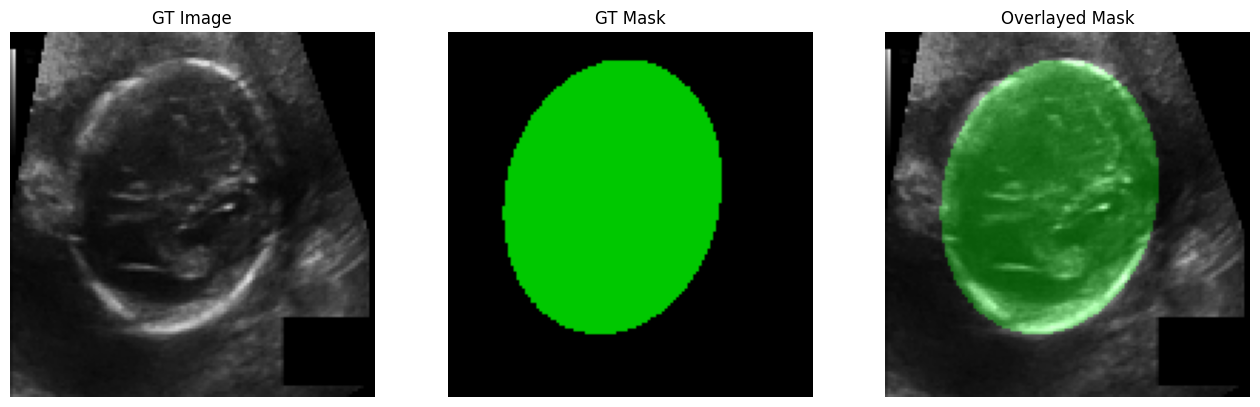

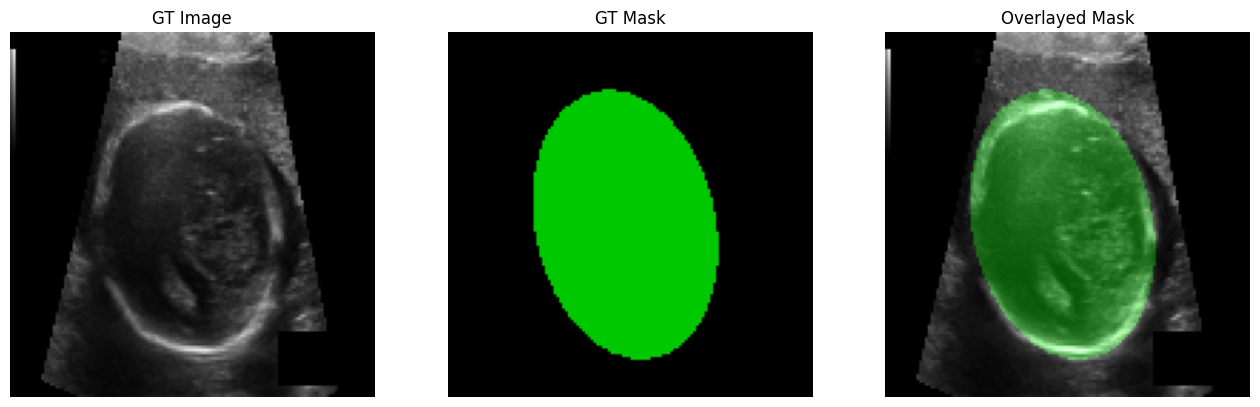

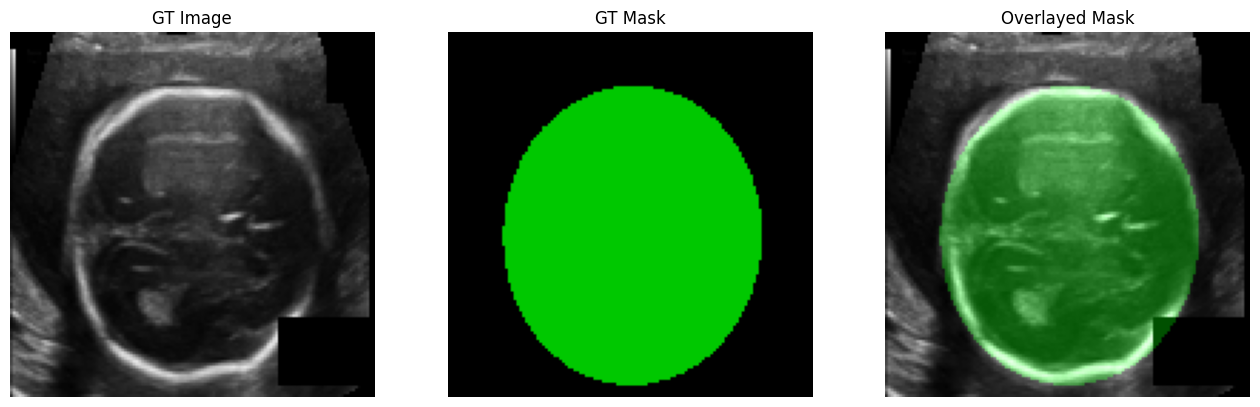

In [58]:
plot_train_ds = train_ds.map(unpackage_inputs).batch(3)
image_batch, mask_batch = next(iter(plot_train_ds.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for image, gt_mask in zip(image_batch, mask_batch):
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask],
                           title_list=titles,
                           figsize=(16, 6),
                           color_mask=True)

## Data Augmentation

We will use the following transforms as augmentations:
* RandomFlip (default mode is **"horizontal"**, with a probability of `0.5`)
* Random Brightness
* Random Contrast

In [59]:
augment_fn = tf.keras.Sequential(
    [
        keras_cv.layers.RandomFlip(),
        keras_cv.layers.RandomBrightness(factor=data_config.BRIGHTNESS_FACTOR,
                                         value_range=(0, 255)),
        keras_cv.layers.RandomContrast(factor=data_config.CONTRAST_FACTOR,
                                       value_range=(0, 255)),
    ]
)

In [60]:
train_dataset = (
                train_ds.shuffle(data_config.BATCH_SIZE)
                .map(augment_fn, num_parallel_calls=tf.data.AUTOTUNE)
                .batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

valid_dataset = (
                valid_ds.batch(data_config.BATCH_SIZE)
                .map(unpackage_inputs)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
)

Let's visualized a few images and their segmentation masks from the training data, with
the `keras_cv.visualization.plot_segmentation_mask_gallery` API.

### Visualize Augmented Data

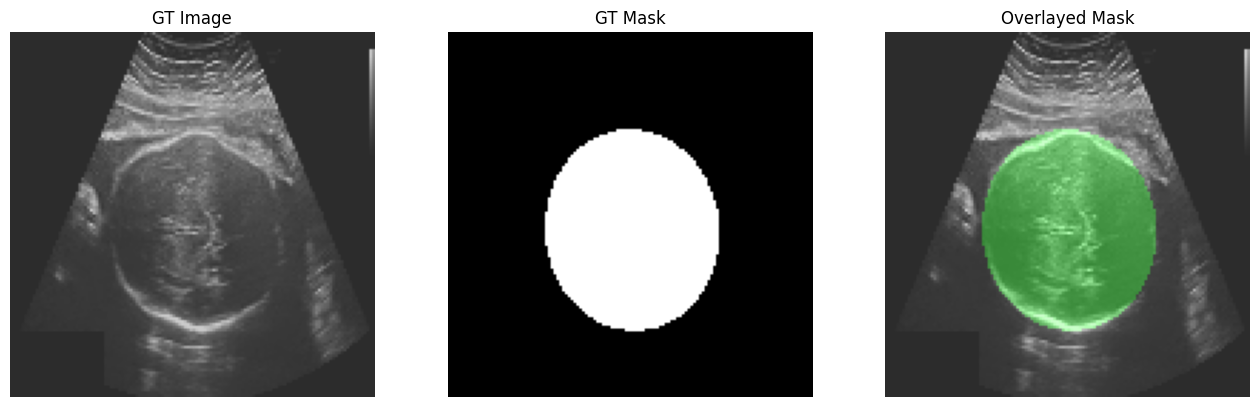

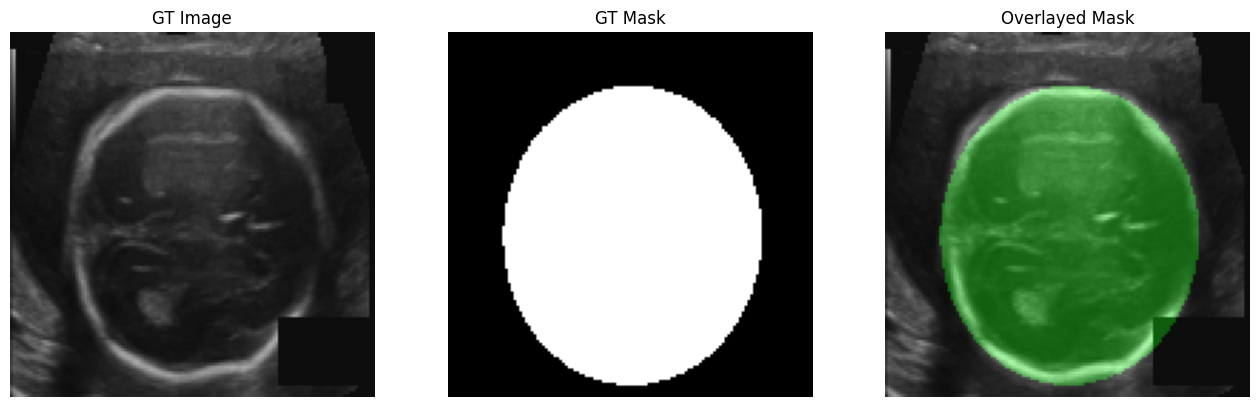

In [61]:
image_batch, aug_mask_batch = next(iter(train_dataset.take(1)))

titles = ["GT Image", "GT Mask", "Overlayed Mask"]

for idx, (image, gt_mask) in enumerate(zip(image_batch, aug_mask_batch)):
    if idx > 1:
        break
    gt_mask = tf.squeeze(gt_mask, axis=-1).numpy()
    display_image_and_mask([image.numpy().astype(np.uint8), gt_mask],
                           title_list=titles,
                           figsize=(16,6),
                           color_mask=False)

## Model Architecture

We will use `resnet50_v2_imagenet` feature extractor on top of the DeepLabv3 Head.

In [62]:
backbone = keras_cv.models.ResNet50V2Backbone.from_preset(preset = train_config.MODEL,
                                                          input_shape=data_config.IMAGE_SIZE+(3,),
                                                          load_weights = True)
model = keras_cv.models.segmentation.DeepLabV3Plus(
        num_classes=data_config.NUM_CLASSES, backbone=backbone,
    )
print(model.summary())

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


Model: "deep_lab_v3_plus_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 model_1 (Functional)        {'P2': (None, 32, 32, 256)   2355660   ['input_2[0][0]']             
                             , 'P5': (None, 4, 4, 2048)   8                                       
                             }                                                                    
                                                                                                  
 spatial_pyramid_pooling_1   (None, 4, 4, 256)            1553817   ['model_1[0][1]']             
 (SpatialPyramidPooling)                                  6                      

## Evaluation Metrics

Intersection over Union (IoU) is a metric often used in segmentation problems to assess the model's accuracy. It provides a more intuitive basis for accuracy that is not biased by the (unbalanced) percentage of pixels from any particular class. Given two segmentation masks, `A` and `B`, the IoU is defined as follows:

$$
IoU = \frac{|A\cap B\hspace{1mm}|}{|A\cup B\hspace{1mm}|} \hspace{2mm}
$$

When there are multiple classes and inferences, we assess the model's performance by computing the mean IoU.

The function below computes the mean IoU that only considers the classes that are present in the ground truth mask or the predicted segmentation map (sometimes referred to as classwise mean IoU). This computation is a better representation of the metric since it only considers the relevant classes. **This is the metric computation we use for mean IoU.**

In [63]:
def mean_iou(y_true, y_pred):

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    y_true = tf.squeeze(y_true, axis=-1)

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=(1, 2))

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=(1, 2)) + tf.math.reduce_sum(y_pred, axis=(1, 2))

    union = total - intersection

    is_class_present =  tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    iou = tf.math.divide_no_nan(intersection, union)
    iou = tf.math.reduce_sum(iou, axis=1) / num_classes_present

    # Compute the mean across the batch axis. Shape: Scalar
    mean_iou = tf.math.reduce_mean(iou)

    return mean_iou

In [68]:
def mean_dice(y_true, y_pred):

    # Get total number of classes from model output.
    num_classes = y_pred.shape[-1]

    y_true = tf.squeeze(y_true, axis=-1)

    y_true = tf.one_hot(tf.cast(y_true, tf.int32), num_classes, axis=-1)
    y_pred = tf.one_hot(tf.math.argmax(y_pred, axis=-1), num_classes, axis=-1)

    # Intersection: |G ∩ P|. Shape: (batch_size, num_classes)
    intersection = tf.math.reduce_sum(y_true * y_pred, axis=(1, 2))

    # Total Sum: |G| + |P|. Shape: (batch_size, num_classes)
    total = tf.math.reduce_sum(y_true, axis=(1, 2)) + tf.math.reduce_sum(y_pred, axis=(1, 2))

    # Compute is_class_present to handle division by zero
    is_class_present = tf.cast(tf.math.not_equal(total, 0), dtype=tf.float32)

    # Number of classes present
    num_classes_present = tf.math.reduce_sum(is_class_present, axis=1)

    # Dice score: 2 * |G ∩ P| / (|G| + |P|)
    dice = tf.math.divide_no_nan(2 * intersection, total)
    dice = tf.math.reduce_sum(dice, axis=1) / num_classes_present

    # Compute the mean across the batch axis. Shape: Scalar
    mean_dice = tf.math.reduce_mean(dice)

    return mean_dice

### Tensorboard and ModelCheckpoint Callbacks

In [69]:
def get_callbacks(
    train_config,
    monitor="val_mean_iou",
    mode="max",
    save_weights_only=True,
    save_best_only=True,
):

    # Initialize tensorboard callback for logging.
    tensorboard_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_config.LOGS_DIR,
        histogram_freq=20,
        write_graph=False,
        update_freq="epoch",
    )


    # Update file path if saving best model weights.
    if save_weights_only:
        checkpoint_filepath = train_config.CKPT_DIR

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=save_weights_only,
        monitor=monitor,
        mode=mode,
        save_best_only=save_best_only,
        verbose=1,
    )

    return [tensorboard_callback, model_checkpoint_callback]

## Train the model

Now let's create the model, compile and train by calling `model.fit()` using the configurations defined in the `Trainingconfig` class.

In [70]:
# Build model.

# Get callbacks.
callbacks = get_callbacks(train_config)
# Define Loss.
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
# Compile model.
model.compile(
    optimizer=tf.keras.optimizers.Adam(train_config.LEARNING_RATE),
    loss=loss_fn,
    metrics=["accuracy", mean_iou, mean_dice],
)

In [71]:
# Train the model, doing validation at the end of each epoch.
history = model.fit(
    train_dataset,
    epochs=35,
    validation_data=valid_dataset,
    callbacks=callbacks
)

Epoch 1/35


96/96 [==============================] - ETA: 0s - loss: 0.2245 - accuracy: 0.9034 - mean_iou: 0.7969 - mean_dice: 0.8745
Epoch 1: val_mean_iou improved from -inf to 0.63816, saving model to checkpoints/deeplabv3_plus_resnet50_v2.h5
96/96 [==============================] - 65s 386ms/step - loss: 0.2245 - accuracy: 0.9034 - mean_iou: 0.7969 - mean_dice: 0.8745 - val_loss: 0.5001 - val_accuracy: 0.7868 - val_mean_iou: 0.6382 - val_mean_dice: 0.7704
Epoch 2/35
96/96 [==============================] - ETA: 0s - loss: 0.1159 - accuracy: 0.9548 - mean_iou: 0.8857 - mean_dice: 0.9345
Epoch 2: val_mean_iou improved from 0.63816 to 0.74715, saving model to checkpoints/deeplabv3_plus_resnet50_v2.h5
96/96 [==============================] - 25s 254ms/step - loss: 0.1159 - accuracy: 0.9548 - mean_iou: 0.8857 - mean_dice: 0.9345 - val_loss: 0.3088 - val_accuracy: 0.8704 - val_mean_iou: 0.7472 - val_mean_dice: 0.8477
Epoch 3/35
96/96 [==============================] - ETA: 0s - loss: 0.0929 - accurac

#### Load Fine-tuned Model Weights

In [72]:
model.load_weights(train_config.CKPT_DIR)

#### Perform Evaluation

In [73]:
evaluate = model.evaluate(valid_dataset)

5/5 [==============================] - 1s 87ms/step - loss: 0.0410 - accuracy: 0.9829 - mean_iou: 0.9588 - mean_dice: 0.9788


## Prediction with Fine-tuned Model

Now that the model training of DeepLabv3 has been completed, let's test it by making predictions on a few sample images.

In [74]:
def inference(model, dataset, samples_to_plot):

    num_batches_to_process = 2
    count = 0
    stop_plot = False

    titles = ["Image", "GT Mask", "Pred Mask", "Overlayed Prediction"]

    for idx, data in enumerate(dataset):

        if stop_plot:
            break

        batch_img, batch_mask = data[0], data[1]
        batch_pred = (model.predict(batch_img)).astype('float32')
        batch_pred = batch_pred.argmax(axis=-1)

        batch_img  = batch_img.numpy().astype('uint8')
        batch_mask = batch_mask.numpy().squeeze(axis=-1)

        for image, mask, pred in zip(batch_img, batch_mask, batch_pred):
            count+=1
            display_image_and_mask([image, mask, pred],
                                  title_list=titles,
                                   figsize=(20,8),
                                   color_mask=True)
            if count >= samples_to_plot:
                stop_plot=True
                break


1/1 [==============================] - 1s 1s/step


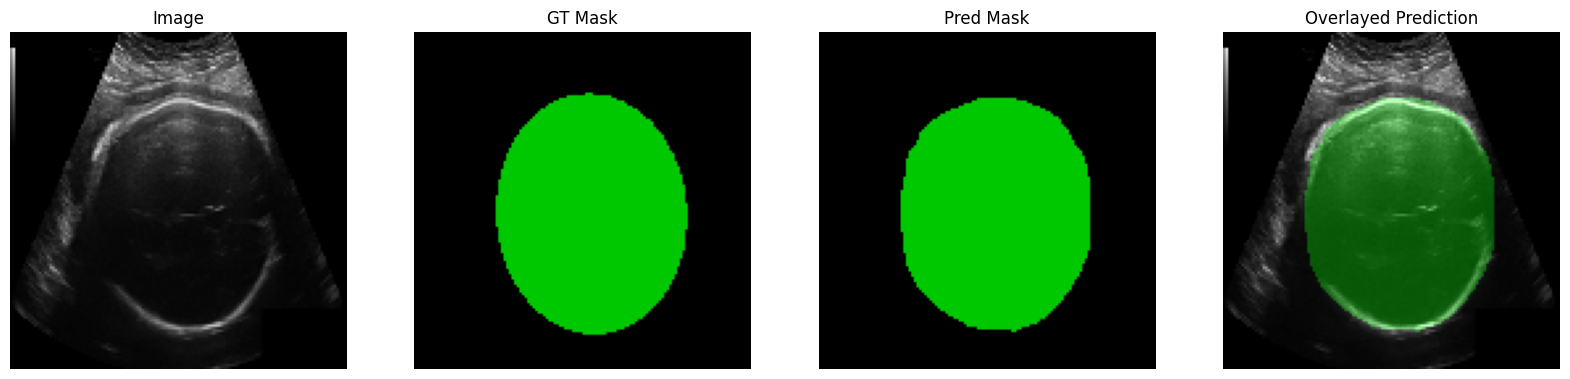

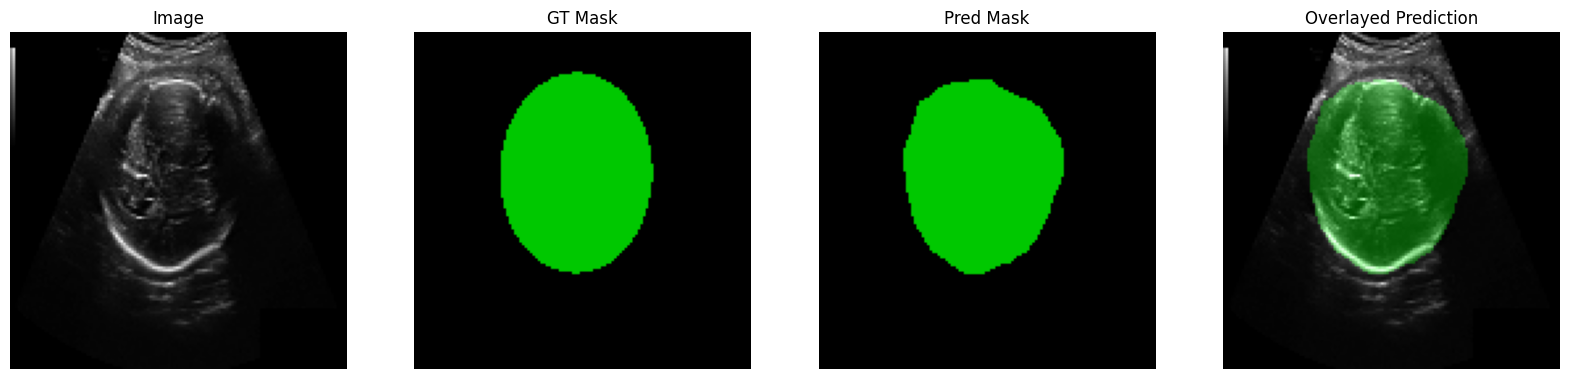

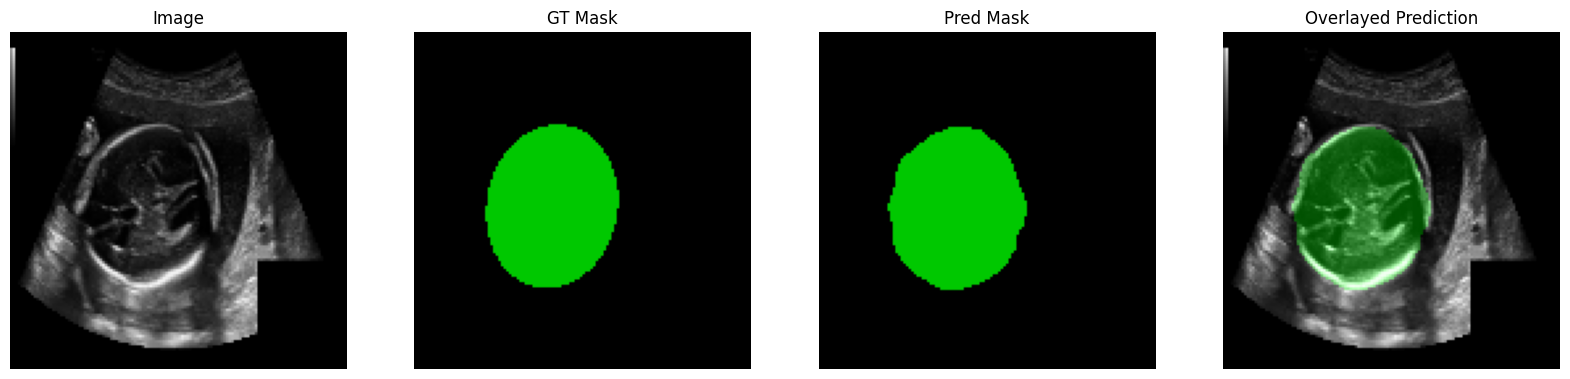

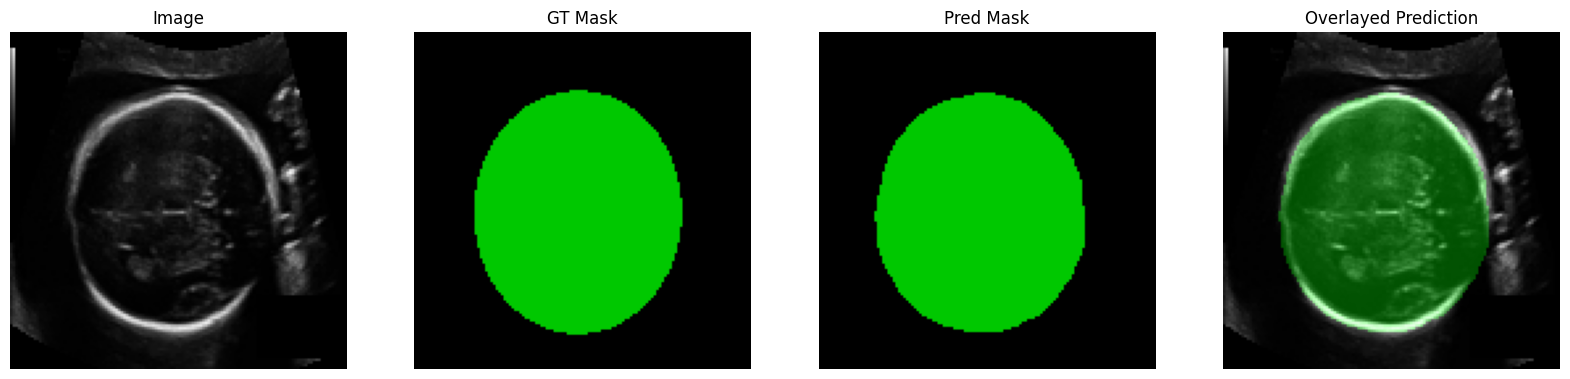

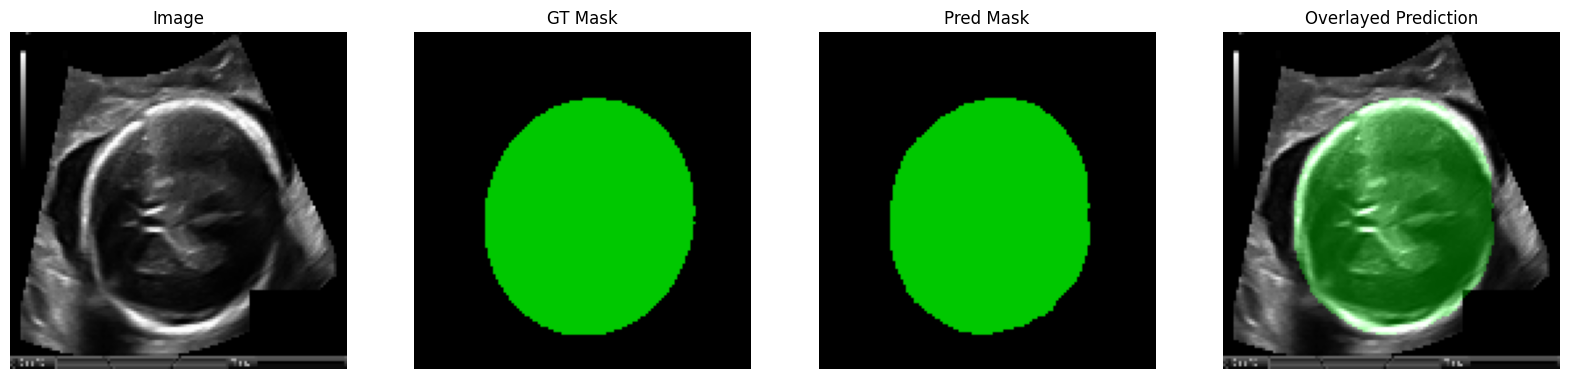

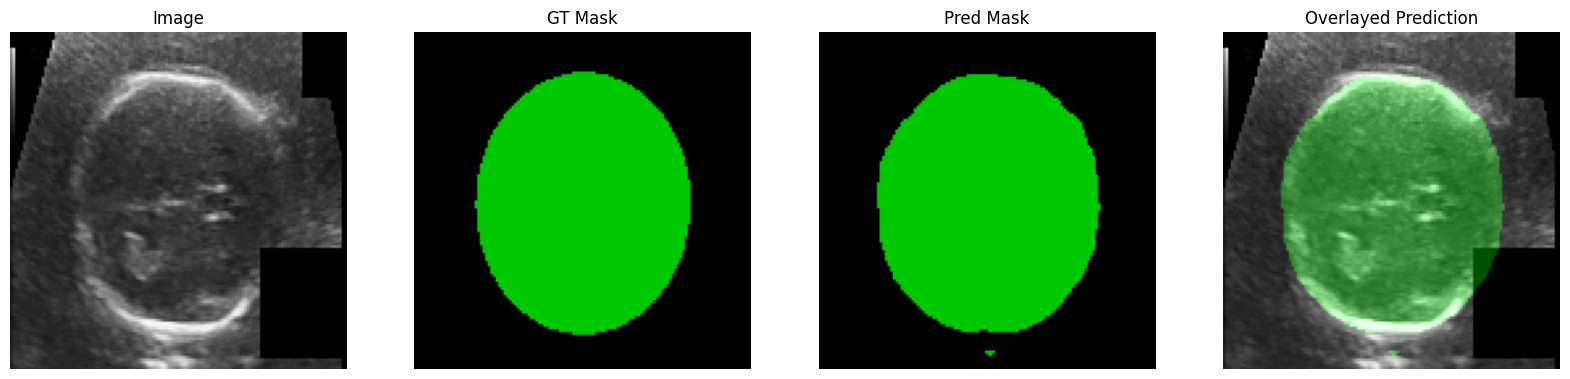

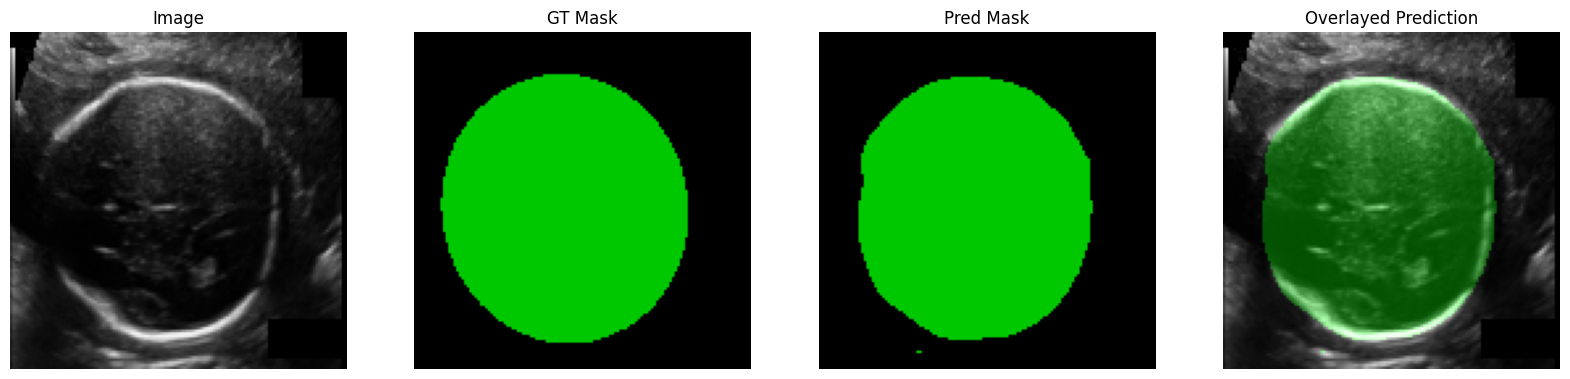

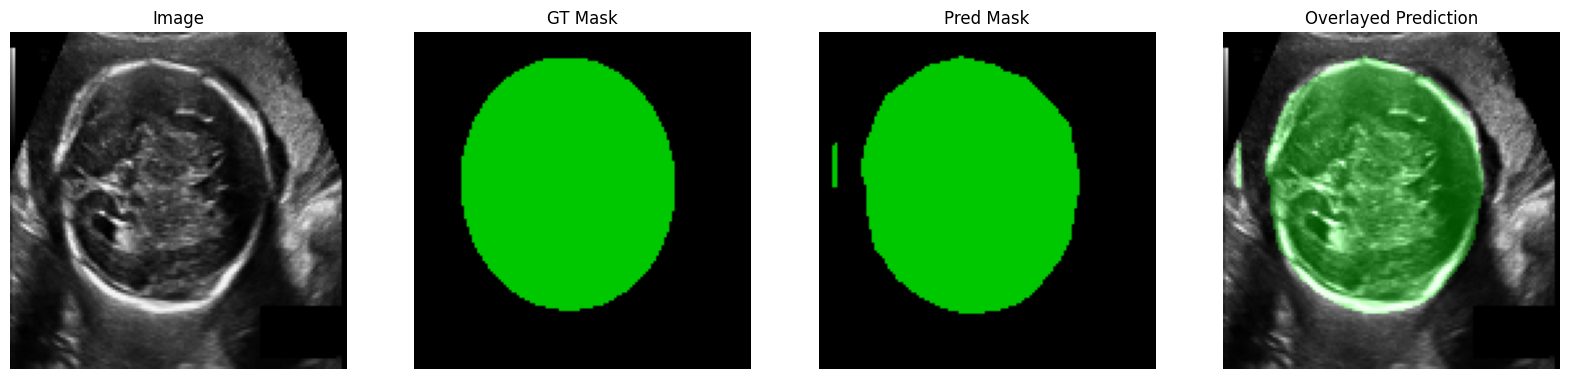

1/1 [==============================] - 0s 117ms/step


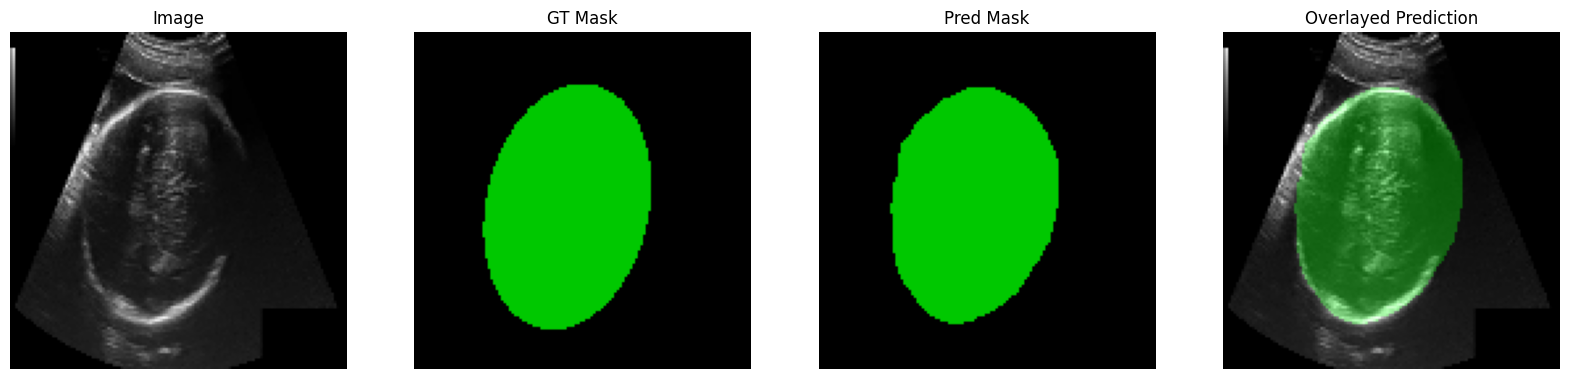

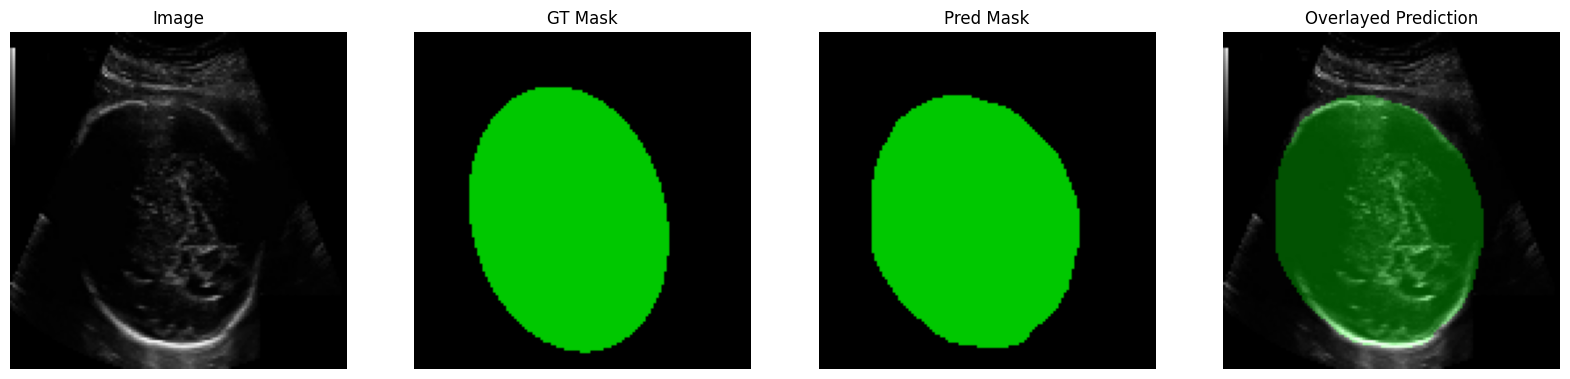

In [75]:
inference(model, valid_dataset, samples_to_plot=10)